In [1]:
from langchain.chat_models import init_chat_model

questions_to_test = {
    "question1": {
        "complexity": "easy",
        "stakeholder": "Cleaning Manager",
        "task": "Ermittlung Standort Sanitärräume",
        "question": "Auf welchen Stockwerken sind Sanitärräume vorhanden?",
        "expected_answer": "EG, 1.OG, 2.OG, 3.OG, 4.OG, 5.OG, 6.OG, 7.OG, 8.OG",
    },
    "question2": {
        "complexity": "easy",
        "stakeholder": "Cleaning Manager",
        "task": "Ermittlung Bodenbeläge",
        "question": "Welche Bodenbeläge gibt es?",
        "expected_answer": "Stein und Zementböden, Stein und Plattenböden, Kunststoffbelege und Linoleum, Parkett und Korkparkett, unbekannt, Gussasphalt und Gummiböden, Textilboden",
    },
    "question3": {
        "complexity": "medium",
        "stakeholder": "Logistics Manager",
        "task": "Flächenmanagement",
        "question": "Gib mir alle Kühlräume mit der Fläche an.",
        "expected_answer": "Kühlraum 00.631 hat eine Gesamtfläche von 6.299m2, Kühlraum 00.632 hat eine Gesamtfläche von 6.299m2, Kühlraum 00.636 hat eine Gesamtfläche von 5.098m2, Kühlraum 00.637 hat eine Gesamtfläche von 8.075m2, Kühlraum 00.638 hat eine Gesamtfläche von 22m2, Kühlraum 00.645 hat eine Gesamtfläche von 7.234m2.",
    },
    "question4": {
        "complexity": "medium",
        "stakeholder": "Cleaning Manager",
        "task": "Ermittlung Fläche Sanitärräume",
        "question": "Welche Flächen haben die einzelnen Sanitärräume ?",
        "expected_answer": "UG = 0m2, EG. = 118,65m2, 1.OG = 39,14m2, 2.OG = 39,14m2, 3.OG = 39,14m2, 4.OG = 39,14m2, 5.OG = 39,14m2, 6.OG = 39,14m2, 7.OG = 39,14m2, 8.OG = 39,14m2, 9.OG = 0m2",
    },
    "question5": {
        "complexity": "hard",
        "stakeholder": "Quality Manager",
        "task": "Qualitätsmanagement",
        "question": "Welcher Schulungsraum ist Flächenmässig der grösste?",
        "expected_answer": "Der Raum Schulung 00.415 ist mit einer Fläche von 41.473m2 der grösste.",
    },
    "question6": {
        "complexity": "hard",
        "stakeholder": "Quality Manager",
        "task": "Qualitätsmanagement",
        "question": "Welche Räumlichkeiten sind für Schulungen zu verwenden?",
        "expected_answer": "Es gibt den Raum Schulung 00.415, Schulungsraum 01.127 und Schulungsraum 01.535.",
    }
}

# Define the list of tables relevant for the LLM queries
RELEVANT_TABLES = [
    "facility",  # Provides overall context for the building/site. Referenced by most other relevant tables.
    "facility_attributes",  # Stores additional properties for facilities if not in direct columns.
    "floor",  # Contains information about building floors (e.g., name, elevation). Links spaces to a specific floor.
    "floor_attributes",  # Stores additional properties for floors (e.g., common floor covering for the entire floor).
    "space",
    # Central table for rooms/spaces. Contains name, type/category (e.g., 'Sanitär', 'Schulung'), area, and link to floor.
    "space_attributes",
    # Links spaces to specific attributes (defined in 'attribute' table) and their values if not direct columns in 'space' (e.g., detailed room function, specific equipment).
    "attribute",
    # Defines the types of attributes that can be assigned to entities (e.g., 'Fläche', 'Bodenbelag', 'Raumfunktion'). Stores the actual value of the attribute.
    "type",
    # A general-purpose typing table. Can be used for various classifications like room types, component types. It also has a 'material' column that might be relevant for floor coverings.
    "material",
    # Contains details about specific materials used, such as 'Bodenbeläge' (floor coverings), identified by name and category.
]

# Set Params to test first
schema_provided = None  # Includes or excludes schema of the usable_table_names()
# The prompt used by the LLM
SYSTEM_PROMPT = """Given an input question, create a syntactically correct {dialect} query to
run to help find the answer. You can order the results by a relevant column to
return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for a the
few relevant columns given the question."""

In [2]:
from langchain_cerebras import ChatCerebras
from dotenv import load_dotenv
import os
# Set up the environment

# Imports for logging
from excel_logger import log_run
from datetime import datetime
from pathlib import Path
import uuid

load_dotenv()

from langchain_core.rate_limiters import InMemoryRateLimiter

rate_limiter = InMemoryRateLimiter(
    requests_per_second=0.1,  # <-- Super slow! We can only make a request once every 10 seconds!!
    check_every_n_seconds=1.0,  # Wake up every 100 ms to check whether allowed to make a request,
    max_bucket_size=10,  # Controls the maximum burst size.
)

# llm = ChatCerebras(
#     model="qwen-3-32b",
#     temperature=0.0,
#     api_key=os.getenv("CEREBRAS_API_KEY"),
#     rate_limiter=rate_limiter,
# )
llm = init_chat_model(
    model="mistral-saba-24b",
    model_provider="groq",
    temperature=0.0,
    api_key=os.getenv("GROQ_API_KEY"),
    rate_limiter=rate_limiter,
)
print(llm)

rate_limiter=<langchain_core.rate_limiters.InMemoryRateLimiter object at 0x000002125ED72BA0> client=<groq.resources.chat.completions.Completions object at 0x000002127F291AC0> async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000002127F56FC50> model_name='mistral-saba-24b' temperature=1e-08 model_kwargs={} groq_api_key=SecretStr('**********')


In [3]:
from typing_extensions import TypedDict


class State(TypedDict):
    question: str
    query: str
    result: str
    answer: str

In [4]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import SystemMessage

query_prompt_template = ChatPromptTemplate.from_messages(
    [
        ("system", SYSTEM_PROMPT),  # Placeholders fill up a **list** of messages
        ("user", "{input}"),
    ]
)

# tools = [ResponseFormatter]
# langgraph_agent_executor = create_react_agent(llm, tools, prompt=prompt)
# messages = langgraph_agent_executor.invoke(
#     {"messages": [("user", query)]},
# )
# print(messages["messages"][-1])

# model_with_tools = llm.bind_tools(tools, tool_choice='required')
# print(model_with_tools.invoke(query))

In [5]:
from sqlalchemy import create_engine
from langchain.sql_database import SQLDatabase

# DB CONNECTION
# SQLAlchemy Engine
engine = create_engine(
    f"postgresql+psycopg2://{os.getenv('DB_USER')}:{os.getenv('DB_PASSWORD')}@{os.getenv('DB_HOST')}:5432/{os.getenv('DB_NAME')}")
db = SQLDatabase(engine, schema="public", include_tables=RELEVANT_TABLES)
db.get_table_info()

C:\Users\Kiril\PycharmProjects\LLM-research\venv\Lib\site-packages\langchain_community\utilities\sql_database.py:338: SAWarning: Cannot correctly sort tables; there are unresolvable cycles between tables "public.contact, public.facility, public.idp_template, public.model, public.project", which is usually caused by mutually dependent foreign key constraints.  Foreign key constraints involving these tables will not be considered; this warning may raise an error in a future release.
  metadata_table_names = [tbl.name for tbl in self._metadata.sorted_tables]
C:\Users\Kiril\PycharmProjects\LLM-research\venv\Lib\site-packages\langchain_community\utilities\sql_database.py:350: SAWarning: Cannot correctly sort tables; there are unresolvable cycles between tables "public.contact, public.facility, public.idp_template, public.model, public.project", which is usually caused by mutually dependent foreign key constraints.  Foreign key constraints involving these tables will not be considered; this 

'\nCREATE TABLE public.attribute (\n\tid BIGINT NOT NULL, \n\tname VARCHAR(255) NOT NULL, \n\tcreated_on TIMESTAMP WITHOUT TIME ZONE, \n\text_system VARCHAR(255), \n\text_object VARCHAR(255), \n\text_identifier VARCHAR(255), \n\tcategory VARCHAR(255), \n\towning_facility_id BIGINT, \n\tcreated_by_id BIGINT, \n\tproperty_id BIGINT, \n\tunit_id BIGINT, \n\tcreated_by_user VARCHAR(50), \n\tcreated_date TIMESTAMP WITHOUT TIME ZONE DEFAULT now(), \n\tlast_modified_by VARCHAR(50), \n\tlast_modified_date TIMESTAMP WITHOUT TIME ZONE, \n\tmodel_id BIGINT, \n\tjhi_value_txt TEXT, \n\tdescription_txt TEXT, \n\tallowed_values_txt TEXT, \n\tCONSTRAINT pk_attribute PRIMARY KEY (id), \n\tCONSTRAINT fk_attribute_created_by_id FOREIGN KEY(created_by_id) REFERENCES public.contact (id) ON DELETE SET NULL, \n\tCONSTRAINT fk_attribute_model_id FOREIGN KEY(model_id) REFERENCES public.model (id) ON DELETE CASCADE, \n\tCONSTRAINT fk_attribute_owning_facility_id FOREIGN KEY(owning_facility_id) REFERENCES publi

In [6]:
from typing_extensions import Annotated


class QueryOutput(TypedDict):
    """Generated SQL query."""

    query: Annotated[str, ..., "Syntactically valid SQL query."]


# def get_table_info_with_schema(db: SQLDatabase) -> str:
#     """Return fully-qualified table and column info with schema."""
#     tables = db.get_usable_table_names()
#     result = []
#     for table in tables:
#         columns = db.get_table_(table)
#         column_info = ", ".join([f"{c.name} ({c.type})" for c in columns])
#         result.append(f"Table public.{table}: {column_info}")
#     return "\n".join(result)

def write_query(state: State):
    """Generate SQL query to fetch information."""
    prompt = query_prompt_template.invoke(
        {
            "dialect": db.dialect,
            "top_k": 15,
            "table_info": db.get_table_info() if schema_provided else None,
            "input": state["question"],
        }
    )
    print(f"Prompt for write_query: {prompt}")

    # Try with structured output first
    structured_llm = llm.with_structured_output(QueryOutput)
    result = structured_llm.invoke(prompt)
    generated_query_str = None
    if isinstance(result, dict):
        # QueryOutput is a TypedDict, so result should be a dict.
        # Safely access the 'query' key.
        generated_query_str = result.get("query")

        if not isinstance(generated_query_str, str):
            print(f"⚠️ LLM output 'query' key exists but its value is not a string: {generated_query_str}. Treating as failure.")
            generated_query_str = None # Reset if not a string
        elif not generated_query_str.strip():
            # If query is an empty string or only whitespace
            print(f"⚠️ LLM generated an empty or whitespace-only query: '{generated_query_str}'. Treating as failure.")
            generated_query_str = None # Reset if empty/whitespace
    else:
        # This case covers result being None or not a dictionary (e.g., parsing failed)
        print(f"⚠️ LLM failed to produce structured output as a dictionary. LLM Output: {result}")
        # generated_query_str remains None

    if generated_query_str is None:
        print("⚠️ Query generation failed or produced an invalid/empty query. Returning an empty string for the query to avoid Pydantic error.")
        # Default to an empty string. This will pass Pydantic validation in the next step,
        # though SQL execution will likely fail for an empty query.
        return {"query": ""}

    return {"query": result["query"]}

# write_query({"question": "How many asset_component are there?"})

In [7]:
from langchain_community.tools.sql_database.tool import QuerySQLDatabaseTool


def execute_query(state: State):
    """Execute SQL query."""
    execute_query_tool = QuerySQLDatabaseTool(db=db)
    return {"result": execute_query_tool.invoke(state["query"])}

# execute_query({"query": "SELECT COUNT(*) FROM public.asset_component"})

In [8]:
def generate_answer(state: State):
    """Answer question using retrieved information as context."""
    prompt = (
        "Given the following user question, corresponding SQL query, "
        "and SQL result, answer the user question.\n\n"
        f'Question: {state["question"]}\n'
        f'SQL Query: {state["query"]}\n'
        f'SQL Result: {state["result"]}'
    )
    response = llm.invoke(prompt)
    print(f"Prompt for generate_answer: {prompt}")
    return {"answer": response.content}

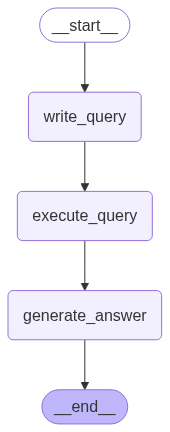

In [9]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence(
    [write_query, execute_query, generate_answer]
)
graph_builder.add_edge(START, "write_query")
graph = graph_builder.compile()

from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
from excel_logger import log_run
from datetime import datetime
from pathlib import Path
import uuid
# Ensure ChatPromptTemplate is available, as it's used to redefine the prompt template.
# It's originally imported in cell 4.
from langchain_core.prompts import ChatPromptTemplate
from langchain_cerebras import ChatCerebras  # Ensure ChatCerebras is imported for re-initialization
import os  # Ensure os is imported for getenv

# NEW: Outer loop for temperatures

print(f"\\n\\n######################################################################")
print(f"LLM Model: {globals()['llm'].model_name}, Temperature: {globals()['llm'].temperature}")
print(f"######################################################################\\n")

# Outer loop for the two schema_provided settings
for current_schema_setting in [True, False]:
    # Update global variables that affect the pipeline behavior.
    # These globals are defined in earlier cells and used by functions like write_query.

    # 1. Update global schema_provided
    # This is directly used by `write_query` and for logging.
    globals()['schema_provided'] = current_schema_setting

    # 2. Update global SYSTEM_PROMPT
    # This is used to create query_prompt_template and for logging.
    _BASE_SYSTEM_PROMPT = """
    Given an input question, create a syntactically correct {dialect} query to run to help find the answer.
    Never query for all the columns from a specific table, only ask for a the few relevant columns given the question.
                           """
    if globals()['schema_provided']:
        current_system_prompt_text = _BASE_SYSTEM_PROMPT + """
        Pay attention to use only the column names that you can see in the schema description. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table. Only use the following tables: {table_info}"""
    else:
        current_system_prompt_text = _BASE_SYSTEM_PROMPT
    globals()['SYSTEM_PROMPT'] = current_system_prompt_text

    # 3. Update global query_prompt_template
    # This is used by `write_query`.
    globals()['query_prompt_template'] = ChatPromptTemplate.from_messages(
        [
            ("system", globals()['SYSTEM_PROMPT']),  # Uses the updated SYSTEM_PROMPT
            ("user", "{input}"),
        ]
    )

    print(f"\\n\\n======================================================================")
    print(f"=== Starting Test Run: schema_provided = {globals()['schema_provided']} ===")
    print(f"======================================================================\\n")

    # Loop through the questions_to_test dictionary (existing inner loop)
    for question_key, question_data in questions_to_test.items():
        current_question = question_data["question"]
        current_complexity = question_data["complexity"]

        current_run_id = str(uuid.uuid4())  # Unique ID for each test case run (question x schema_setting x temp)
        accumulated_state = {"question": current_question}  # Initialize with the current question

        print(
            f"\\n--- Starting Run for: {question_key} (schema_provided={globals()['schema_provided']} ---")
        print(f"Run ID: {current_run_id}")
        print(f"Question: {current_question}")
        print(f"Complexity: {current_complexity}")

        for step_output in graph.stream(
                {"question": current_question}, stream_mode="updates"
        ):
            print("--------------------STREAM OUTPUT--------------------")
            print(step_output)  # Print the raw step output
            for node_name, output_value in step_output.items():
                if isinstance(output_value, dict):
                    accumulated_state.update(output_value)
                else:
                    accumulated_state[node_name] = output_value
            print("----------------ACCUMULATED STATE--------------------")
            print(accumulated_state)

        print("\\nGraph execution finished.")
        print(
            f"Final accumulated state for {question_key} (schema_provided={globals()['schema_provided']}: {accumulated_state}")

        excel_file_path = Path("data/experiment_results.xlsx")
        # llm is now defined in the outer loop
        llm_temperature = globals()['llm'].temperature  # Directly access temperature

        # Format the timestamp
        current_timestamp_str = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

        row_to_log = {
            "timestamp": current_timestamp_str,  # Use formatted timestamp string
            "llm_name": globals()['llm'].model_name if hasattr(globals()['llm'], 'model_name') else 'N/A',
            "temperature": llm_temperature,  # Log the current temperature
            "system_prompt": globals()['SYSTEM_PROMPT'],  # Use the current SYSTEM_PROMPT for this iteration
            "schema_provided": globals()['schema_provided'],
            # Use the current schema_provided setting for this iteration
            "question_complexity": current_complexity,  # Use complexity from the current question
            "stakeholder": question_data.get("stakeholder", "N/A"),  # Added stakeholder
            "task": question_data.get("task", "N/A"),  # Added task
            "question": accumulated_state.get("question", current_question),
            "generated_sql": accumulated_state.get("query"),
            "sql_execution_result": str(accumulated_state.get("result")) if accumulated_state.get(
                "result") is not None else None,
            "answer": accumulated_state.get("answer"),
            "expected_answer": question_data.get("expected_answer", "N/A"),  # Added expected_answer
            "run_id": current_run_id
        }

        print(
            f"\\nLogging data for run {current_run_id} ({question_key}, schema_provided={globals()['schema_provided']}:")
        for key, value in row_to_log.items():
            print(f"  {key}: {value}")

        try:
            log_run(row_dict=row_to_log, excel_path=excel_file_path)
            print(f"Successfully logged run {current_run_id} ({question_key}) to {excel_file_path.resolve()}")
        except Exception as e:
            print(f"Error logging run {current_run_id} ({question_key}): {e}")
        print(
            f"--- Finished Run for: {question_key} (schema_provided={globals()['schema_provided']} ---")

print(f"\\n\\n======================================================================")
print(f"=== All Test Runs Completed ===")
print(f"======================================================================\\n")

\n\n######################################################################
LLM Model: mistral-saba-24b, Temperature: 1e-08
######################################################################\n
\n\n======================================================================
=== Starting Test Run: schema_provided = True ===
======================================================================\n
\n--- Starting Run for: question1 (schema_provided=True ---
Run ID: 17087980-0743-4d1c-939d-bddbfb25a58a
Question: Auf welchen Stockwerken sind Sanitärräume vorhanden?
Complexity: easy


C:\Users\Kiril\PycharmProjects\LLM-research\venv\Lib\site-packages\langchain_community\utilities\sql_database.py:338: SAWarning: Cannot correctly sort tables; there are unresolvable cycles between tables "public.contact, public.facility, public.idp_template, public.model, public.project", which is usually caused by mutually dependent foreign key constraints.  Foreign key constraints involving these tables will not be considered; this warning may raise an error in a future release.
  metadata_table_names = [tbl.name for tbl in self._metadata.sorted_tables]
C:\Users\Kiril\PycharmProjects\LLM-research\venv\Lib\site-packages\langchain_community\utilities\sql_database.py:350: SAWarning: Cannot correctly sort tables; there are unresolvable cycles between tables "public.contact, public.facility, public.idp_template, public.model, public.project", which is usually caused by mutually dependent foreign key constraints.  Foreign key constraints involving these tables will not be considered; this 

Prompt for write_query: messages=[SystemMessage(content='\n    Given an input question, create a syntactically correct postgresql query to run to help find the answer.\n    Never query for all the columns from a specific table, only ask for a the few relevant columns given the question.\n                           \n        Pay attention to use only the column names that you can see in the schema description. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table. Only use the following tables: \nCREATE TABLE public.attribute (\n\tid BIGINT NOT NULL, \n\tname VARCHAR(255) NOT NULL, \n\tcreated_on TIMESTAMP WITHOUT TIME ZONE, \n\text_system VARCHAR(255), \n\text_object VARCHAR(255), \n\text_identifier VARCHAR(255), \n\tcategory VARCHAR(255), \n\towning_facility_id BIGINT, \n\tcreated_by_id BIGINT, \n\tproperty_id BIGINT, \n\tunit_id BIGINT, \n\tcreated_by_user VARCHAR(50), \n\tcreated_date TIMESTAMP WITHOUT TIME ZONE DEFAULT now(), \

C:\Users\Kiril\PycharmProjects\LLM-research\venv\Lib\site-packages\langchain_community\utilities\sql_database.py:338: SAWarning: Cannot correctly sort tables; there are unresolvable cycles between tables "public.contact, public.facility, public.idp_template, public.model, public.project", which is usually caused by mutually dependent foreign key constraints.  Foreign key constraints involving these tables will not be considered; this warning may raise an error in a future release.
  metadata_table_names = [tbl.name for tbl in self._metadata.sorted_tables]
C:\Users\Kiril\PycharmProjects\LLM-research\venv\Lib\site-packages\langchain_community\utilities\sql_database.py:350: SAWarning: Cannot correctly sort tables; there are unresolvable cycles between tables "public.contact, public.facility, public.idp_template, public.model, public.project", which is usually caused by mutually dependent foreign key constraints.  Foreign key constraints involving these tables will not be considered; this 

Prompt for write_query: messages=[SystemMessage(content='\n    Given an input question, create a syntactically correct postgresql query to run to help find the answer.\n    Never query for all the columns from a specific table, only ask for a the few relevant columns given the question.\n                           \n        Pay attention to use only the column names that you can see in the schema description. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table. Only use the following tables: \nCREATE TABLE public.attribute (\n\tid BIGINT NOT NULL, \n\tname VARCHAR(255) NOT NULL, \n\tcreated_on TIMESTAMP WITHOUT TIME ZONE, \n\text_system VARCHAR(255), \n\text_object VARCHAR(255), \n\text_identifier VARCHAR(255), \n\tcategory VARCHAR(255), \n\towning_facility_id BIGINT, \n\tcreated_by_id BIGINT, \n\tproperty_id BIGINT, \n\tunit_id BIGINT, \n\tcreated_by_user VARCHAR(50), \n\tcreated_date TIMESTAMP WITHOUT TIME ZONE DEFAULT now(), \

C:\Users\Kiril\PycharmProjects\LLM-research\venv\Lib\site-packages\langchain_community\utilities\sql_database.py:338: SAWarning: Cannot correctly sort tables; there are unresolvable cycles between tables "public.contact, public.facility, public.idp_template, public.model, public.project", which is usually caused by mutually dependent foreign key constraints.  Foreign key constraints involving these tables will not be considered; this warning may raise an error in a future release.
  metadata_table_names = [tbl.name for tbl in self._metadata.sorted_tables]
C:\Users\Kiril\PycharmProjects\LLM-research\venv\Lib\site-packages\langchain_community\utilities\sql_database.py:350: SAWarning: Cannot correctly sort tables; there are unresolvable cycles between tables "public.contact, public.facility, public.idp_template, public.model, public.project", which is usually caused by mutually dependent foreign key constraints.  Foreign key constraints involving these tables will not be considered; this 

Prompt for write_query: messages=[SystemMessage(content='\n    Given an input question, create a syntactically correct postgresql query to run to help find the answer.\n    Never query for all the columns from a specific table, only ask for a the few relevant columns given the question.\n                           \n        Pay attention to use only the column names that you can see in the schema description. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table. Only use the following tables: \nCREATE TABLE public.attribute (\n\tid BIGINT NOT NULL, \n\tname VARCHAR(255) NOT NULL, \n\tcreated_on TIMESTAMP WITHOUT TIME ZONE, \n\text_system VARCHAR(255), \n\text_object VARCHAR(255), \n\text_identifier VARCHAR(255), \n\tcategory VARCHAR(255), \n\towning_facility_id BIGINT, \n\tcreated_by_id BIGINT, \n\tproperty_id BIGINT, \n\tunit_id BIGINT, \n\tcreated_by_user VARCHAR(50), \n\tcreated_date TIMESTAMP WITHOUT TIME ZONE DEFAULT now(), \

C:\Users\Kiril\PycharmProjects\LLM-research\venv\Lib\site-packages\langchain_community\utilities\sql_database.py:338: SAWarning: Cannot correctly sort tables; there are unresolvable cycles between tables "public.contact, public.facility, public.idp_template, public.model, public.project", which is usually caused by mutually dependent foreign key constraints.  Foreign key constraints involving these tables will not be considered; this warning may raise an error in a future release.
  metadata_table_names = [tbl.name for tbl in self._metadata.sorted_tables]
C:\Users\Kiril\PycharmProjects\LLM-research\venv\Lib\site-packages\langchain_community\utilities\sql_database.py:350: SAWarning: Cannot correctly sort tables; there are unresolvable cycles between tables "public.contact, public.facility, public.idp_template, public.model, public.project", which is usually caused by mutually dependent foreign key constraints.  Foreign key constraints involving these tables will not be considered; this 

Prompt for write_query: messages=[SystemMessage(content='\n    Given an input question, create a syntactically correct postgresql query to run to help find the answer.\n    Never query for all the columns from a specific table, only ask for a the few relevant columns given the question.\n                           \n        Pay attention to use only the column names that you can see in the schema description. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table. Only use the following tables: \nCREATE TABLE public.attribute (\n\tid BIGINT NOT NULL, \n\tname VARCHAR(255) NOT NULL, \n\tcreated_on TIMESTAMP WITHOUT TIME ZONE, \n\text_system VARCHAR(255), \n\text_object VARCHAR(255), \n\text_identifier VARCHAR(255), \n\tcategory VARCHAR(255), \n\towning_facility_id BIGINT, \n\tcreated_by_id BIGINT, \n\tproperty_id BIGINT, \n\tunit_id BIGINT, \n\tcreated_by_user VARCHAR(50), \n\tcreated_date TIMESTAMP WITHOUT TIME ZONE DEFAULT now(), \

C:\Users\Kiril\PycharmProjects\LLM-research\venv\Lib\site-packages\langchain_community\utilities\sql_database.py:338: SAWarning: Cannot correctly sort tables; there are unresolvable cycles between tables "public.contact, public.facility, public.idp_template, public.model, public.project", which is usually caused by mutually dependent foreign key constraints.  Foreign key constraints involving these tables will not be considered; this warning may raise an error in a future release.
  metadata_table_names = [tbl.name for tbl in self._metadata.sorted_tables]
C:\Users\Kiril\PycharmProjects\LLM-research\venv\Lib\site-packages\langchain_community\utilities\sql_database.py:350: SAWarning: Cannot correctly sort tables; there are unresolvable cycles between tables "public.contact, public.facility, public.idp_template, public.model, public.project", which is usually caused by mutually dependent foreign key constraints.  Foreign key constraints involving these tables will not be considered; this 

Prompt for write_query: messages=[SystemMessage(content='\n    Given an input question, create a syntactically correct postgresql query to run to help find the answer.\n    Never query for all the columns from a specific table, only ask for a the few relevant columns given the question.\n                           \n        Pay attention to use only the column names that you can see in the schema description. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table. Only use the following tables: \nCREATE TABLE public.attribute (\n\tid BIGINT NOT NULL, \n\tname VARCHAR(255) NOT NULL, \n\tcreated_on TIMESTAMP WITHOUT TIME ZONE, \n\text_system VARCHAR(255), \n\text_object VARCHAR(255), \n\text_identifier VARCHAR(255), \n\tcategory VARCHAR(255), \n\towning_facility_id BIGINT, \n\tcreated_by_id BIGINT, \n\tproperty_id BIGINT, \n\tunit_id BIGINT, \n\tcreated_by_user VARCHAR(50), \n\tcreated_date TIMESTAMP WITHOUT TIME ZONE DEFAULT now(), \

C:\Users\Kiril\PycharmProjects\LLM-research\venv\Lib\site-packages\langchain_community\utilities\sql_database.py:338: SAWarning: Cannot correctly sort tables; there are unresolvable cycles between tables "public.contact, public.facility, public.idp_template, public.model, public.project", which is usually caused by mutually dependent foreign key constraints.  Foreign key constraints involving these tables will not be considered; this warning may raise an error in a future release.
  metadata_table_names = [tbl.name for tbl in self._metadata.sorted_tables]
C:\Users\Kiril\PycharmProjects\LLM-research\venv\Lib\site-packages\langchain_community\utilities\sql_database.py:350: SAWarning: Cannot correctly sort tables; there are unresolvable cycles between tables "public.contact, public.facility, public.idp_template, public.model, public.project", which is usually caused by mutually dependent foreign key constraints.  Foreign key constraints involving these tables will not be considered; this 

Prompt for write_query: messages=[SystemMessage(content='\n    Given an input question, create a syntactically correct postgresql query to run to help find the answer.\n    Never query for all the columns from a specific table, only ask for a the few relevant columns given the question.\n                           \n        Pay attention to use only the column names that you can see in the schema description. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table. Only use the following tables: \nCREATE TABLE public.attribute (\n\tid BIGINT NOT NULL, \n\tname VARCHAR(255) NOT NULL, \n\tcreated_on TIMESTAMP WITHOUT TIME ZONE, \n\text_system VARCHAR(255), \n\text_object VARCHAR(255), \n\text_identifier VARCHAR(255), \n\tcategory VARCHAR(255), \n\towning_facility_id BIGINT, \n\tcreated_by_id BIGINT, \n\tproperty_id BIGINT, \n\tunit_id BIGINT, \n\tcreated_by_user VARCHAR(50), \n\tcreated_date TIMESTAMP WITHOUT TIME ZONE DEFAULT now(), \